In [110]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan

k_neighbors = 50
k_neighbors += 1

In [61]:
patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata.shape

(46520, 6984)

In [62]:
#Build L Matrix
ANNOY_PATH = "../../../large_data_files"
annoy_path = os.path.join(ANNOY_PATH, "200214_patient_similarity_clusters_default.ann")

cos_knn_tree = AnnoyIndex(pdata.shape[1], "angular")
cos_knn_tree.load(annoy_path)

gamma = 2
print("Building dense data matrix with k={} nn...".format(k_neighbors))
A = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    nn_idxs = cos_knn_tree.get_nns_by_item(i, k_neighbors)[1:]
    cos_distances = [cos_knn_tree.get_distance(i, nn) for nn in nn_idxs]
    rbf_distances = [np.exp(-gamma*cos_dist**2) for cos_dist in cos_distances]
    A[i, nn_idxs] = rbf_distances

  0%|          | 1/46520 [00:00<1:43:03,  7.52it/s]

Building dense data matrix with k=2001 nn...


100%|██████████| 46520/46520 [32:43<00:00, 23.70it/s]


In [63]:
knn_adj = {}
for i in tqdm(range(A.shape[0])):
    nn_idx = set(np.nonzero(A[i])[0])
    knn_adj[i] = nn_idx
    
for i in tqdm(range(A.shape[0])):
    nns = knn_adj[i]
    for nn in nns:
        if i not in knn_adj[nn]:
            A[i, nn] = 0

pickle.dump(csr_matrix(A), open("./data/A_mknn_K{}_CSR.p".format(k_neighbors - 1), "wb"))

100%|██████████| 46520/46520 [02:09<00:00, 359.57it/s]


In [111]:
# A = pickle.load(open("A_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))
# A_nns_per_node = [np.nonzero(row)[0].shape[0] for row in A]
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors - 1), "rb"))
D = np.zeros((A.shape[0], A.shape[0]))
for i in tqdm(range(A.shape[0])):
    D[i, i] = np.sum(A[i])
    
pickle.dump(csr_matrix(D), open("./data/D_mknn_K{}_CSR.p".format(k_neighbors - 1), "wb"))

 65%|██████▍   | 30149/46520 [00:09<00:04, 3334.93it/s]


KeyboardInterrupt: 

In [112]:
k_neighbors = 50
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

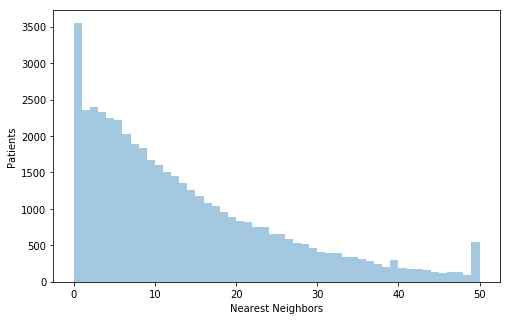

In [113]:
mknn_nns_per_node = [np.nonzero(row)[0].shape[0] for row in A]
plt.figure(figsize=(8,5))
ax = sns.distplot(mknn_nns_per_node, kde=False)
ax.set(xlabel="Nearest Neighbors", ylabel="Patients")
plt.savefig("./figures/mknn_featdist_K{}.png".format(k_neighbors))

# Compute regularized D

In [114]:
nonzero_idx = np.nonzero(D)
D_mean = np.mean(D[nonzero_idx])
print(D_mean)

D_mc = D.copy()
D_mc[nonzero_idx] = D[nonzero_idx] + D_mean
print(np.mean(D_mc[nonzero_idx]), np.mean(D[nonzero_idx]))

3.366392505543628
6.732785011087256 3.366392505543628


In [115]:
pickle.dump(csr_matrix(D_mc), open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

# Compute normalized L

In [125]:
use_mc = True

In [126]:
if use_mc:
    D = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
else:
    D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

In [127]:
nonzero_idx = np.nonzero(D)
D_diag_sqrt_inv = 1.0/np.sqrt(D[nonzero_idx])
D_inv_sqrt = D.copy()
D_inv_sqrt[nonzero_idx] = D_diag_sqrt_inv

In [128]:
if use_mc:
    pickle.dump(D_inv_sqrt, open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))
else:
    pickle.dump(D_inv_sqrt, open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))

In [129]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

if use_mc:
    D_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
else:
    D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

print("computing L...")
L = D_inv_sqrt.multiply(A.multiply(D_inv_sqrt))
print("Done.")

if use_mc:
    pickle.dump(csr_matrix(L), open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))
else:
    pickle.dump(csr_matrix(L), open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

computing L...
Done.


# Eigen Decomposition

In [143]:
use_mc = True

In [144]:
k_neighbors = 50
if use_mc:
    L = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb")).toarray()
else:
    L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb")).toarray()

print("Found nans:", np.any(np.isnan(L)))

evals=100
L_evals, L_evecs = scipy.sparse.linalg.eigsh(L, k=evals + 1, which="LM")

Found nans: False


Nans shape: (0, 1)


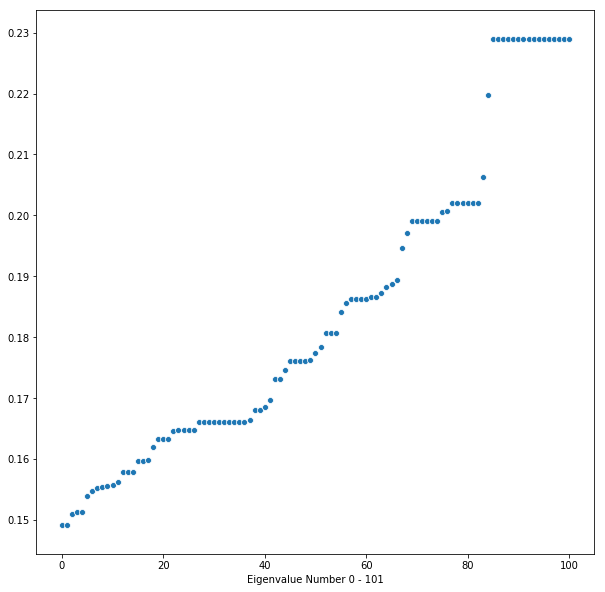

In [145]:
L_nan_idxs = np.argwhere(np.isnan(L_evals))
print("Nans shape:", L_nan_idxs.shape)

plt.figure(figsize=(10,10))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)
ax.set(xlabel="Eigenvalue Number 0 - {}".format(evals + 1))
if use_mc:
    plt.savefig("./figures/evals_L_mc_evals{}_K{}.png".format(evals, k_neighbors))
else:
    plt.savefig("./figures/evals_L_evals{}_K{}.png".format(evals, k_neighbors))

In [142]:
print(L_evals[-20:])

[0.63085776 0.63085776 0.67568545 0.84430289 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


# Top K Eigenvectors

In [134]:
drop_k_evals = 16
top_k_evecs=3
knn_clusters = 4
lc=100
visualizer = Visualizer()

In [135]:
print("Mean Correction?", use_mc)
print("K", k_neighbors)
print("drop_k_evals", drop_k_evals)
print("top_k_evecs", top_k_evecs)
print("knn_clusters", knn_clusters)

Mean Correction? False
K 50
drop_k_evals 16
top_k_evecs 3
knn_clusters 4


In [136]:
X_top_k = L_evecs[:, -drop_k_evals-top_k_evecs:-drop_k_evals]
L_evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
Y_top_k = X_top_k / L_evecs_lengths_top_k[:, None]

print(X_top_k.shape)
print(Y_top_k.shape)

(46520, 3)
(46520, 3)


In [137]:
if use_mc:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))
else:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: './data/Y_umap_2d_K50_topkevecs3_lc100.p'

In [138]:
Y_umap_2d = visualizer.umap_embedding(Y_top_k, n_components=2, lc=lc)
Y_umap_3d = visualizer.umap_embedding(Y_top_k, n_components=3, lc=lc)

if use_mc:
    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))
else:
    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))

./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


In [139]:
if use_mc:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), 'rb'))
else:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: './data/cluster_labels_K50_knn4_topkevecs3.p'

In [140]:
Y_kmeans_top_k = KMeans(n_clusters=knn_clusters).fit(Y_top_k)
Y_cluster_labels = Y_kmeans_top_k.labels_

if use_mc:
    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), "wb"))
else:
    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), "wb"))
print("Cluster labels:", np.unique(Y_cluster_labels))

Cluster labels: [0 1 2 3]


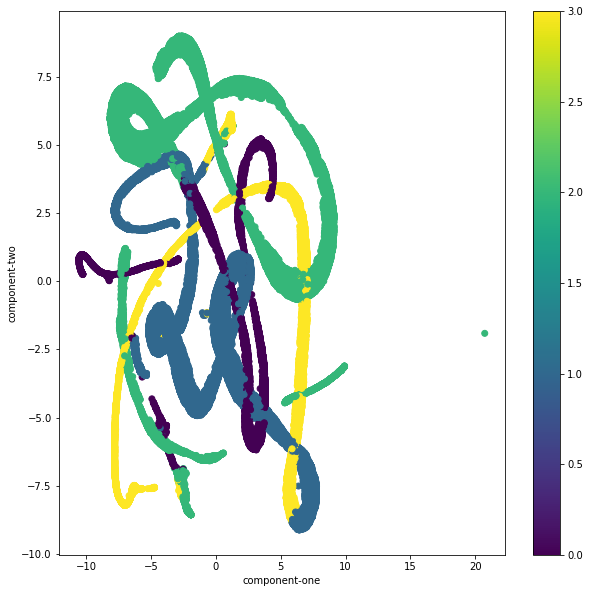

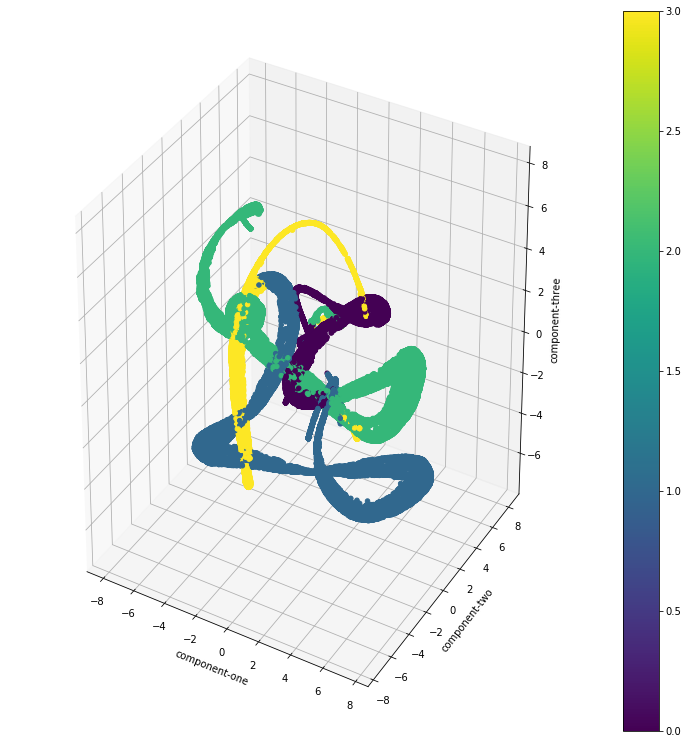

In [141]:
alpha = 1

if use_mc:
    filename_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, top_k_evecs, knn_clusters)
    filename_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, top_k_evecs, knn_clusters)
else:
    filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, top_k_evecs, knn_clusters)
    filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, top_k_evecs, knn_clusters)   

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

# Eigenvector Analysis

In [7]:
evecs_to_plot=5

In [8]:
print("Mean Correction?", use_mc)
print("K", k_neighbors)
print("drop_k_evals", drop_k_evals)
print("top_k_evecs", top_k_evecs)
print("knn_clusters", knn_clusters)
print("evecs_to_plot", evecs_to_plot)

Mean Correction? False
K 2000
drop_k_evals 1
top_k_evecs 5
knn_clusters 4
evecs_to_plot 5


[Text(0.5,0,'Eigenvalue Number 0 - 101')]

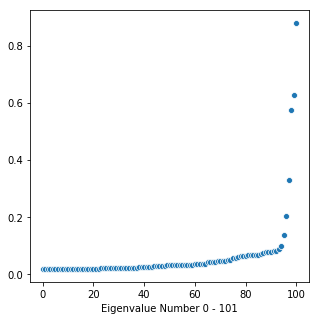

In [9]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)
ax.set(xlabel="Eigenvalue Number 0 - {}".format(evals + 1))

In [10]:
# X_top_k = L_evecs[:, -drop_k_evals-top_k_evecs:-drop_k_evals]
k_evecs = L_evecs[:, -evecs_to_plot:]
evec_cols = ["Evec_{}".format(i) for i in range(evecs_to_plot)]
evec_df = pd.DataFrame(k_evecs, columns=evec_cols)

print(evec_df.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4
count  4.652000e+04  4.652000e+04  4.652000e+04  4.652000e+04  4.652000e+04
mean   2.149613e-05  2.149613e-05 -2.149613e-05  2.149613e-05 -2.149613e-05
std    4.636392e-03  4.636392e-03  4.636392e-03  4.636392e-03  4.636392e-03
min   -1.717403e-15 -2.947540e-16 -1.000000e+00 -1.180566e-16 -1.000000e+00
25%   -7.864335e-19 -7.601554e-19 -3.955165e-19 -2.908760e-19 -7.785379e-19
50%   -8.794775e-21 -8.834742e-21  4.812786e-21 -3.240421e-21 -8.729315e-21
75%    7.717133e-19  7.447045e-19  4.027003e-19  2.861821e-19  7.605273e-19
max    1.000000e+00  1.000000e+00  5.635325e-16  1.000000e+00  7.787406e-16


In [11]:
quantiles = []
for i in range(evecs_to_plot):
    q1 = evec_df["Evec_{}".format(i)].quantile(0.25)
    q2 = evec_df["Evec_{}".format(i)].quantile(0.75)
    quantiles.append((q1, q2))

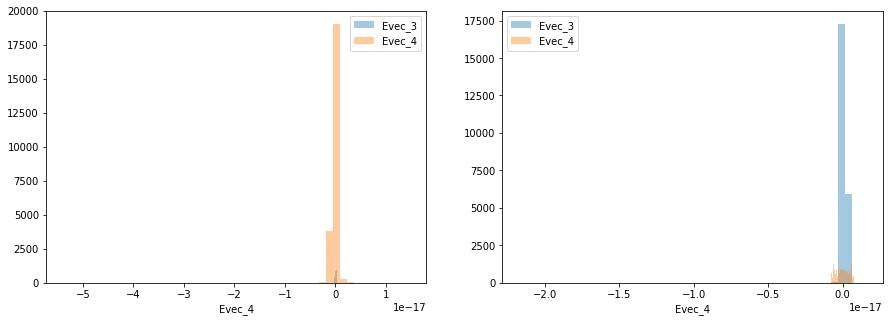

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
evec_i = 3

prev_colname = "Evec_{}".format(evec_i)
next_colname = "Evec_{}".format(evec_i + 1)

prev_quantiles = evec_df[(evec_df[prev_colname] >= quantiles[evec_i][0]) & 
                         (evec_df[prev_colname] <= quantiles[evec_i][1])]
sns.distplot(prev_quantiles[prev_colname], kde=False, label=prev_colname, ax=axes[0])
sns.distplot(prev_quantiles[next_colname], kde=False, label=next_colname, ax=axes[0])
axes[0].legend()

next_quantiles = evec_df[(evec_df[next_colname] >= quantiles[evec_i + 1][0]) & 
                         (evec_df[next_colname] <= quantiles[evec_i + 1][1])]
sns.distplot(next_quantiles[prev_colname], kde=False, label=prev_colname, ax=axes[1])
sns.distplot(next_quantiles[next_colname], kde=False, label=next_colname, ax=axes[1])
axes[1].legend()

if use_mc:
    plt.savefig("./figures/evecs_distplot_{}vs{}_L_mc_K{}.png".format(evec_i, evec_i+1, k_neighbors))
else:
    plt.savefig("./figures/evecs_distplot_{}vs{}_L_K{}.png".format(evec_i, evec_i+1, k_neighbors))


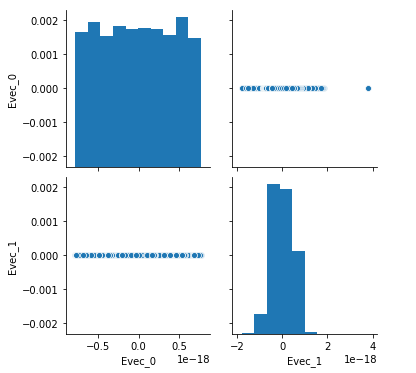

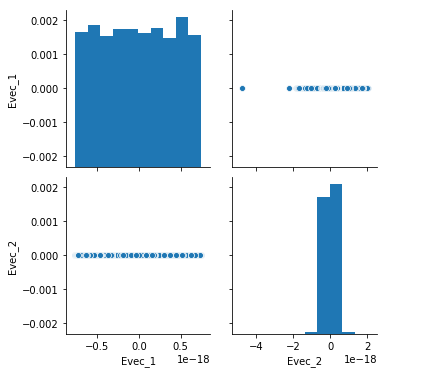

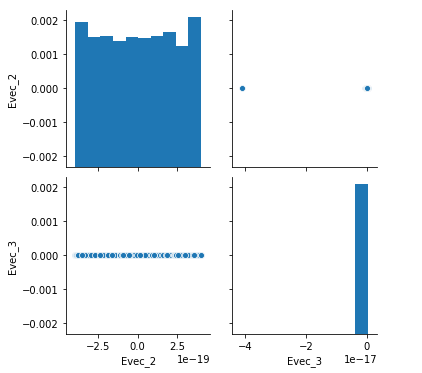

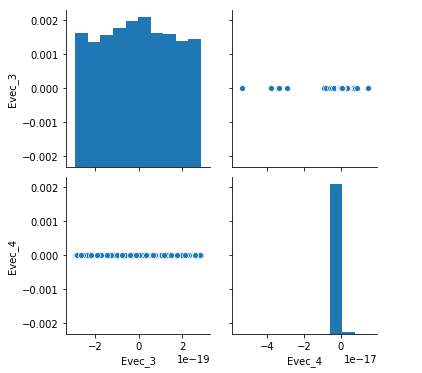

In [35]:
for evec_i in range(evecs_to_plot - 1):
    evec_colname = "Evec_{}".format(evec_i)
    evec_quantiles = evec_df[(evec_df[evec_colname] >= quantiles[evec_i][0]) & 
                             (evec_df[evec_colname] <= quantiles[evec_i][1])]
    sns.pairplot(evec_quantiles[["Evec_{}".format(evec_i), "Evec_{}".format(evec_i+1)]])
#     if use_mc:
#         plt.savefig("./figures/evecs_pairplot_{}vs{}_L_mc_K{}.png".format(evec_i, evec_i+1, k_neighbors))
#     else:
#         plt.savefig("./figures/evecs_pairplot_{}vs{}_L_K{}.png".format(evec_i, evec_i+1, k_neighbors))

#MAKE THIS PLOT FUNCTION A BIT MORE GENERAL. U NOTICE HOW EVEC4 vs EVEC3 SAYS A LOT ABOUT HOW THE CLUSTERS CAN FORM

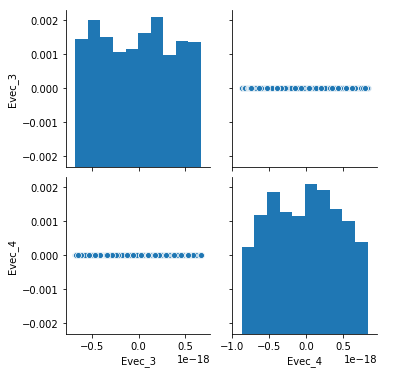

In [320]:
sns.pairplot(evec_quantiles.iloc[:2000])

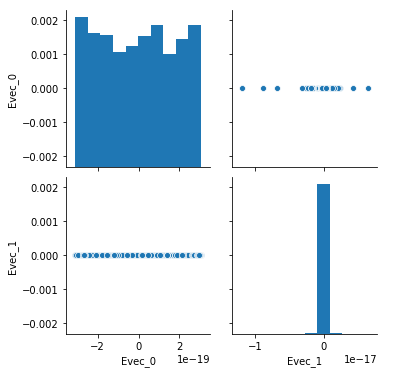

# Other

In [146]:
Y_umap_2d
Y_cluster_labels
Y_umap_2d[:, 0]

array([-6.07638311,  4.03776121, -2.87236547, ...,  0.5460341 ,
        1.40882909,  3.90277886])

In [ ]:
alpha = 1

if use_mc:
    filename_2d = "./figures/umap2d_mc_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)
    filename_3d = "./figures/umap3d_mc_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)
else:
    filename_2d = "./figures/umap2d_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)
    filename_3d = "./figures/umap3d_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)   

data2d = {"umap_1": Y_umap_2d[:, 0].tolist(), 
          "umap_2": Y_umap_2d[:, 1].tolist(), 
          "cluster": Y_cluster_labels.tolist()}

data3d = {"umap_1": Y_umap_3d[:, 0].tolist(), 
          "umap_2": Y_umap_3d[:, 1].tolist(), 
          "umap_3": Y_umap_3d[:, 2].tolist(), 
          "cluster": Y_cluster_labels.tolist()}

In [ ]:
plt.figure(figsize=(15,15))
ax2d = sns.scatterplot(x='umap_1', y='umap_2', hue='cluster', palette="bright", data=df2d)
plt.legend(loc="upper left")

## Standardized Decomposition

In [ ]:
L_standardized = pickle.load(open("L_standardized_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))
L_standardized

In [ ]:
L_std = np.std(L, axis=0)
L_mean = np.mean(L, axis=0)
print(np.nonzero(L_std)[0])
print(np.nonzero(L_mean)[0])
print(np.all(np.nonzero(L_std)[0] == np.nonzero(L_mean)[0]))
print("^ This means mean and std are nonzero at exactly the same places...")

L_standardized = np.subtract(L, L_mean, where=L_std!=0)
L_standardized = np.divide(L, L_std, where=L_std!=0)

In [ ]:
print(np.mean(L_standardized[:, 67]))
print(np.std(L_standardized[:, 67]))

In [ ]:
pickle.dump(csr_matrix(L_standardized), open("L_standardized_sym_K{}_CSR.p".format(k_neighbors - 1), "wb"))

In [ ]:
e_std = 100
L_standardized_evals, L_standardized_evecs = scipy.sparse.linalg.eigsh(L_standardized, k=e_std)

L_standardized_nan_idxs = np.argwhere(np.isnan(L_standardized_evals))
print("Nans shape:", L_standardized_nan_idxs.shape)

plt.figure(figsize=(10,10))
sns.scatterplot(range(L_standardized_evals.shape[0]), L_standardized_evals)
plt.savefig("eigen_vals_eigs{}_L_standardized_K{}.png".format(e_std, k_neighbors - 1))

In [ ]:
pickle.dump(L_standardized_evals, open("L_standardized_evals_eigs{}_K{}.p".format(e_std, k_neighbors - 1), "wb"))

In [ ]:
a = np.array([[1,1,1],[2,2,2],[3,3,3]])
b = np.array([1,2,3])

print(a / b[:, None])

# Cluster

In [ ]:
X = L_evecs
L_evecs_lengths = np.linalg.norm(X, axis=1)

Y = X / L_evecs_lengths[:, None]

In [ ]:
Y_pca = PCA().fit(Y.T)

In [ ]:
n_feats = 5
print(np.sum(Y_pca.explained_variance_ratio_[:n_feats]))

In [ ]:
Y_pca_feats = Y_pca.components_[:n_feats].T
Y_pca_feats.shape

In [ ]:
n_clusters = 3
Y_kmeans = KMeans(n_clusters=n_clusters).fit(Y_pca_feats)
Y_cluster_labels = Y_kmeans.labels_
np.unique(Y_cluster_labels)

In [ ]:
visualizer = Visualizer()
Y_umap_2d = visualizer.umap_embedding(Y_pca_feats, n_components=2)
Y_umap_3d = visualizer.umap_embedding(Y_pca_feats, n_components=3)

pickle.dump(Y_umap_2d, open("Y_umap_2d_pca{}.p".format(n_feats), 'wb'))
pickle.dump(Y_umap_3d, open("Y_umap_3d_pca{}.p".format(n_feats), 'wb'))

In [ ]:
Y_umap_2d = pickle.load(open("Y_umap_2d_pca{}.p".format(n_feats), 'rb'))
Y_umap_3d = pickle.load(open("Y_umap_3d_pca{}.p".format(n_feats), 'rb'))

alpha = 1
visualizer.plot2d(
    X=Y_umap_2d, 
    filename="Patient_Clusters_2D_spectral_K{}_eig{}_pca{}_clusters{}".format(k_neighbors - 1, eigs, n_feats, n_clusters), 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename="Patient_Clusters_3D_spectral_K{}_eig{}_pca{}_clusters{}".format(k_neighbors - 1, eigs, n_feats, n_clusters), 
    colors=Y_cluster_labels,
    alpha = alpha
)

# HDBSCAN

In [ ]:
n_feats = 8
minclustersize = 10

Y_pca_feats = Y_pca.components_[:n_feats].T

hdbscanner = hdbscan.HDBSCAN(min_cluster_size=minclustersize).fit(Y_pca_feats)
hdbscan_labels = hdbscanner.fit_predict(Y_pca_feats)
np.unique(hdbscan_labels, return_counts=True)

In [ ]:
visualizer = Visualizer()
Y_umap_2d = visualizer.umap_embedding(Y_pca_feats, n_components=2)
Y_umap_3d = visualizer.umap_embedding(Y_pca_feats, n_components=3)

pickle.dump(Y_umap_2d, open("Y_umap_2d_pca{}.p".format(n_feats), 'wb'))
pickle.dump(Y_umap_3d, open("Y_umap_3d_pca{}.p".format(n_feats), 'wb'))

In [ ]:
Y_umap_2d = pickle.load(open("Y_umap_2d_pca{}.p".format(n_feats), 'rb'))
Y_umap_3d = pickle.load(open("Y_umap_3d_pca{}.p".format(n_feats), 'rb'))

alpha = 1
visualizer.plot2d(
    X=Y_umap_2d, 
    filename="Patient_Clusters_2D_spectral_HDB_K{}_eig{}_pca{}_minclustersize{}".format(k_neighbors - 1, eigs, n_feats, minclustersize), 
    colors=hdbscan_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename="Patient_Clusters_3D_spectral_HDB_K{}_eig{}_pca{}_minclustersize{}".format(k_neighbors - 1, eigs, n_feats, minclustersize), 
    colors=hdbscan_labels,
    alpha = alpha
)

# Misc

In [ ]:
icd_idx = 0
icd_row = A_sym[icd_idx]
has_icd = np.nonzero(icd_row)[1]
has_icd

In [ ]:
def sort_pdata(pdata, unwanted = set([])):
    icd_x_patients = pdata.T
    sorted_idx = []
    seen = set([])

    for icd_idx in tqdm(range(icd_x_patients.shape[0])):
        if icd_idx in unwanted:
            continue
        icd_row = icd_x_patients[icd_idx]
        has_icd = set(np.nonzero(icd_row)[1])
        has_icd -= seen
        sorted_idx += list(has_icd)
        seen.update(sorted_idx)
        
    icd_x_patients_sorted = pdata[sorted_idx].T
    print(len(seen))
    return icd_x_patients_sorted

A_sorted = sort_pdata(A_sym)
A_sorted[A_sorted > 0] = 1

In [ ]:
plt.figure(figsize=(40, 20))
sns.heatmap(A_sorted.toarray()[:2000, :2000])
plt.savefig("heatmap_A_K{}.png".format(k_neighbors - 1))